# JULIA TYPES

In [77]:
struct Bernoulli #weighted coin flip
    p::Float64
    
end

## Extending Julia Methods to use our new type

In [78]:
Base.rand(X::Bernoulli) = Int(rand() < X.p)

In [80]:
B = Bernoulli(0.25)

Bernoulli(0.25)

In [81]:
methods(Bernoulli) # Julia creates automatically 2 constructor methods with the same name of the type

# 2 methods for type constructor:
[1] Bernoulli(p::Float64) in Main at In[77]:2
[2] Bernoulli(p) in Main at In[77]:2

### Now I can use Bernoulli with a base function Rand

In [45]:
rand(B)

0

In [68]:
B.p

0.25

In [69]:
B.c

0.1

In [88]:
using Statistics, Plots, PlutoUI, LinearAlgebra, Symbolics

# Random variables as types


This lecture might appear to be about random variables (and it is). But we would be thrilled if you see it rather as a more general discussion on software engineering and abstractions, since the principles involved extend to *many* different contexts.


Recall that a **random variable** $X$ is an object which has different possible **outcomes** $x$, to which we assign **probabilities** $\mathbb{P}(X = x)$.

The correspondence of probabilities to outcomes is called the **probability distribution** of the random variable.

## Gaussian distributions

Let's remind ourselves of a very important type of distribution, namely the **Gaussian distribution** with mean $\mu$ and standard deviation $\sigma$ (or variance $\sigma^2$).

We can sample from a Gaussian distribution with mean $0$ and variance $1$ with the `randn` function (short for "random normal"). We can then shift and scale to get the Gaussian distribution that we want:

In [90]:
μ=0; σ =1;

In [91]:
data = μ .+ σ .* randn(10^5)   # transform standard normal

100000-element Vector{Float64}:
 -1.3601233706869145
  0.32377924012733605
 -0.16563505572135595
  2.220677237713658
 -0.5636850282481745
 -0.07524356238929693
 -0.24232164867808442
  0.8827412000546562
 -0.9571588944125851
 -0.6133455076665362
  0.37271802620566025
  0.4564767294611939
  1.2011696051634253
  ⋮
  0.24984007167173783
 -1.0404521288284014
  0.6819855310299998
  0.856782234485574
 -0.8547314427038798
  1.4757315264871333
  1.2629640457293143
 -0.6144619957735259
  0.8074826011547367
 -0.6781483485903602
  0.06781045623949561
 -0.7940985221170174

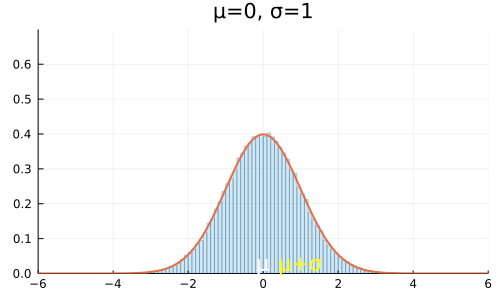

In [96]:
histogram(data, alpha=0.2, norm=true, bins=100, leg=false, title="μ=$(μ), σ=$(σ)", size=(500, 300))
xlims!(-6, 6)
ylims!(0, 0.7)


xs = [μ - σ, μ, μ + σ]

plot!(-6:0.01:6, x -> bell_curve(x, μ, σ), lw=2)


annotate!(μ, 0.03, text("μ", :white))
annotate!(μ + σ, 0.03, text("μ+σ", :yellow))
annotate!(μ, 0.03, text("μ", :white))




In [93]:
bell_curve(x, μ, σ) = bell_curve( (x - μ) / σ ) / σ

bell_curve (generic function with 1 method)

In [95]:
bell_curve(x) = exp(-x^2 / 2) / √(2π)

bell_curve (generic function with 2 methods)

# Why define a type at all?

How can we *represent a random variable* in software?

In some languages there are different names for the various functions associated to a random variable, but no name for the random variable itself!

For example, in R there is a standard naming convention in R, with `d` for density, etc., followed by the name like `norm` for normal. The indicators are:

- `d` for the density
- `p` for the distribution function
- `q` for the quantile function
- `r` for generating random variates

See e.g.
- [Normal distribution in R](https://www.rdocumentation.org/packages/stats/versions/3.6.2/topics/Normal)

- [Chi-squared distribution in R](https://www.rdocumentation.org/packages/stats/versions/3.6.2/topics/Chisquare)


What's wrong with this? All these functions are referring to an underlying random variable (or probability distribution), which you will find in any course in probability, and yet there's no way to refer to the underlying mathematical object!

Instead, we would like to be able to refer to the random variable (or probability distribution) itself. We should be able to provide a type with the name and parameters of a random variable, but not yet specify how to generate random instances (variates)? It turns out that this is a very good example of thinking ahead by providing an **abstraction**.

We can *later* provide a means for random sampling -- and even, if a new algorithm comes along that is more efficient, we can replace it some day!

## Defining abstract types for random variables

We define an abstract type using abstract type <Name> end, where <Name> is replaced with the name of the type.

We can think of an abstract type as being a collection of types that share a particular property. In our case, we want to create a type to represent "any random variable", and also the sub-types "any continuous(-valued) random variable" and "any discrete(-valued) random variable".

This will allow us to specify later on whether a given concrete (i.e. particular) random variable is discrete or continuous.

We use <: to denote sub-type:

In [97]:
abstract type RandomVariable end

abstract type DiscreteRandomVariable <: RandomVariable end
abstract type ContinuousRandomVariable <: RandomVariable end

## Defining a type for a Gaussian random variable

Let's start off by looking at **Gaussian** random variables, also called normal random variables. We reminded ourselves above what they look like.

In [98]:
struct Gaussian <: ContinuousRandomVariable
    μ     # mean
    σ²    # variance
end
    
    
    

In [99]:
Gaussian() = Gaussian(0.0, 1.0) #normalized Gaussian mean 0 and Variance 1

Gaussian

In [100]:
G = Gaussian(1, 2)

Gaussian(1, 2)

### Theoretical mean and variance

Now we can extend the `mean`, `var` (variance) and `std` (standard deviation) functions from the `Statistics` library to act on this object:

In [101]:
Statistics.mean(X::Gaussian) = X.μ
Statistics.var(X::Gaussian) = X.σ²

In [102]:
mean(G)

1

In [104]:
var(G)

2

### Planning ahead: Standard deviation for *any* random variable, not just Gaussians

Once we have defined the variance, we know how to calculate the standard deviation: it's just the square root of the variance. But, thinking ahead, this is true for *any* random variable, so we can define it to act on any random variable that we will define later!:

In [106]:
Statistics.std(X::RandomVariable) = sqrt(var(X))

This is an example of good software design.

In [108]:
std(G)

1.4142135623730951

Gaussians have a special property: the sum of two Gaussians is always a Gaussian. (We say that Gaussians are **stable** distributions; [there are others](https://en.wikipedia.org/wiki/Stable_distribution).) Note that we don't need random samples for this theoretical observation, embodied in the following code:

In [110]:
G1 = Gaussian(0, 1)
G2 = Gaussian(5, 6)

Gaussian(5, 6)

In [111]:
G1+G2

LoadError: MethodError: no method matching +(::Gaussian, ::Gaussian)
[0mClosest candidates are:
[0m  +(::Any, ::Any, [91m::Any[39m, [91m::Any...[39m) at operators.jl:560
[0m  +([91m::ChainRulesCore.Composite{P, T} where T[39m, ::P) where P at C:\Users\gjunq\.julia\packages\ChainRulesCore\D0go7\src\differential_arithmetic.jl:132
[0m  +([91m::ChainRulesCore.AbstractThunk[39m, ::Any) at C:\Users\gjunq\.julia\packages\ChainRulesCore\D0go7\src\differential_arithmetic.jl:108
[0m  ...

In [113]:
Base.:+(X::Gaussian, Y::Gaussian) = Gaussian(X.μ + Y.μ, X.σ² + Y.σ²)

In [114]:
G1+G2

Gaussian(5, 7)

In [115]:
mean(G1 + G2) == mean(G1) + mean(G2)

true

The theoretical product of two Gaussians is not Gaussian; we will do the general case later.

A Gaussian random variable is a **continuous** random variable, i.e. it has a continuous range of possible outcomes. The possible range of outcomes is called the **support** of the distribution. For a Gaussian it is the whole real line, $(-\infty, \infty)$.


One way to specify a continous random variable $X$ is via its **probability density function**, or **PDF**, $f_X$. The probability that $X$ lies in the interval $[a, b]$ is given by an area under the curve $f_X(x)$ from $a$ to $b$:

$$\mathbb{P}(X \in [a, b]) = \int_{a}^b f_X(x) \, dx.$$
    

For a Gaussian distribution with mean $\mu$ and variance $\sigma^2$, the PDF is given by

$$f_X(X) = \frac{1}{\sqrt{2\pi \sigma^2}} \exp \left[ -\frac{1}{2} \left( \frac{x - \mu}{\sigma} \right)^2 \right]$$.


In [116]:
pdf(X::Gaussian) = x -> exp(-0.5 * ( (x - X.μ)^2 / X.σ²) ) / √(2π * X.σ²)

pdf (generic function with 1 method)

In [117]:
pdf(G)

#7 (generic function with 1 method)

In [118]:
pdf(Gaussian())(0.0)

0.3989422804014327

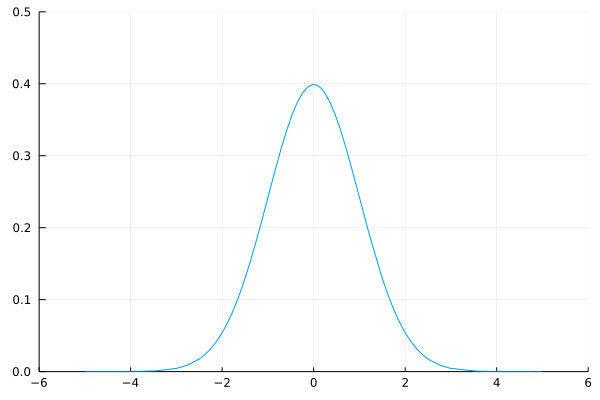

In [120]:
plot(pdf(Gaussian(0.0, 1.0)), leg=false)
xlims!(-6, 6)
ylims!(0, 0.5)

### Sampling from a Gaussian distribution

We can also specify how to sample from a Gaussian distribution. We can re-purpose `rand` for this!

In [121]:
Base.rand(X::Gaussian) = X.μ + √(X.σ²) * randn()

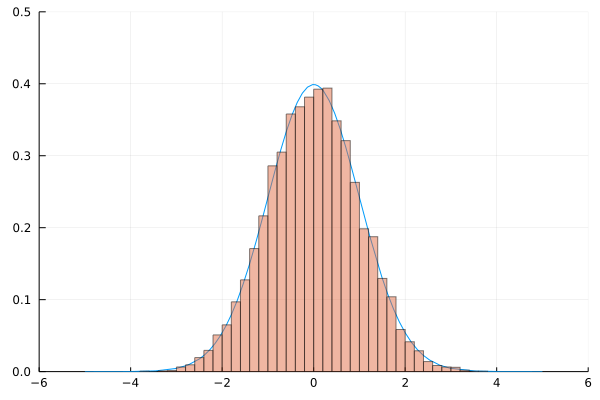

In [123]:
histogram!([rand(Gaussian(0.0, 1.0)) for i in 1:10^4], alpha=0.5, norm=true)

# More general distributions

Let's recall the Bernoulli distribution from last lecture. This represents a weighted coin with probability $p$ to come up "heads" (1), and probability $1-p$ to come up "tails" (0).

Note that this is a **discrete** random variable: the possible outcomes are the discrete values $0$ and $1$.

In [126]:
struct Bernnouli <: DiscreteRandomVariable
p::Float64
end

In [128]:
B = Bernnouli(0.25)

Bernnouli(0.25)

Again we can specify the theoretical mean and variance:

In [129]:
Statistics.mean(X::Bernnouli) = X.p
Statistics.var(X::Bernnouli) = X.p * (1 - X.p)

In [130]:
mean(B), var(B), std(B)

(0.25, 0.1875, 0.4330127018922193)

And again `std` just works!

Finally we specify how to sample:

In [132]:
Base.rand(X::Bernnouli) = Int(rand() < X.p)

## Adding two random variables

What happens if we add two Bernoulli random variables? There are two routes we could go: We could use the known theoretical sum, or we could write a general-purpose tool. Let's do the latter.

When we add two Bernoulli random variables we do not get a Bernoulli back. To see this it's enough to observe that the sum can have the outcome 2, which is impossible for a Bernoulli.

So the result is just the random variable "the sum of these two given random variables". In general it won't even have a common name.

So we actually need to define a new type to represent the "sum of two given random variables", which itself will be a random variable!:

In [133]:
B1 = Bernnouli(0.25)
B2 = Bernnouli(0.6)

Bernnouli(0.6)

In [134]:
B1+B2

LoadError: MethodError: no method matching +(::Bernnouli, ::Bernnouli)
[0mClosest candidates are:
[0m  +(::Any, ::Any, [91m::Any[39m, [91m::Any...[39m) at operators.jl:560
[0m  +([91m::ChainRulesCore.Composite{P, T} where T[39m, ::P) where P at C:\Users\gjunq\.julia\packages\ChainRulesCore\D0go7\src\differential_arithmetic.jl:132
[0m  +([91m::ChainRulesCore.AbstractThunk[39m, ::Any) at C:\Users\gjunq\.julia\packages\ChainRulesCore\D0go7\src\differential_arithmetic.jl:108
[0m  ...

In [135]:
struct SumOfTwoRandomVariables <: RandomVariable
X1::RandomVariable
X2::RandomVariable
end

In [136]:
Base.:+(X1::RandomVariable, X2::RandomVariable) = SumOfTwoRandomVariables(X1, X2)

In [137]:
B1+B2

SumOfTwoRandomVariables(Bernnouli(0.25), Bernnouli(0.6))

In [138]:
G1+G2

Gaussian(5, 7)

Now we need to define the various functions on this type representing a sum

In [150]:
Statistics.mean(S::SumOfTwoRandomVariables) = mean(S.X1) + mean(S.X2)

To have a simple equation for the variance, we need to assume that the two random variables are **independent**. Perhaps the name should have been `SumOfTwoIndependentRandomVariables`, but it seems too long.

In [151]:
Statistics.var(S::SumOfTwoRandomVariables) = var(S.X1) + var(S.X2)

How can we sample from the sum? It's actually easy!

In [152]:
Base.rand(S::SumOfTwoRandomVariables) = rand(S.X1) + rand(S.X2)

Now it's easy to look at the sum of a Bernoulli and a Gaussian. This is an example of a [**mixture distribution**](https://en.wikipedia.org/wiki/Mixture_distribution).

Let's extend the `histogram` function to easily draw the histogram of a random variable:

In [145]:
Plots.histogram(X::RandomVariable; kw...) = histogram([rand(X) for i in 1:10^6], norm=true, leg=false, alpha=0.5, size=(500, 300), kw...)

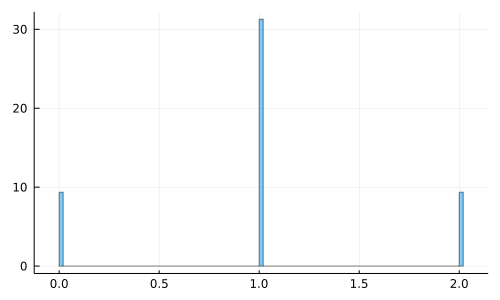

In [153]:
histogram(Bernnouli(0.25) + Bernnouli(0.75))

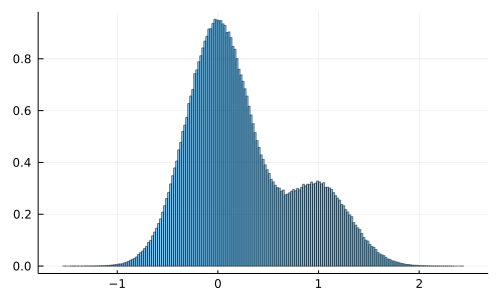

In [155]:
histogram(Bernnouli(0.25) + Gaussian(0, 0.1))

Now... What if we sum more random variables?

In [156]:
mixture = Bernnouli(0.25) + Bernnouli(0.75) + Gaussian(0, 0.1)

SumOfTwoRandomVariables(SumOfTwoRandomVariables(Bernnouli(0.25), Bernnouli(0.75)), Gaussian(0, 0.1))

In [157]:
rand( mixture )

1.7715758091534668

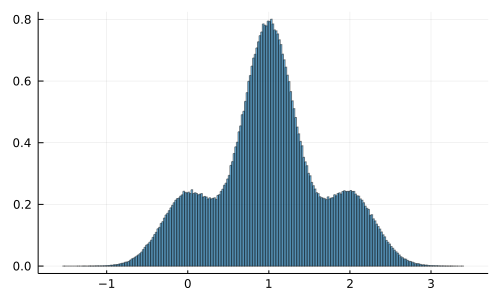

In [158]:
histogram( mixture )

## χ₁² distribution

Another well-known distribution is the chi-squared distribution, which is defined as the sum of squares of Gaussians. Chi-1 squared ($\chi_1^2$) is the square of a single Gaussian:

In [160]:
struct ChiSquared1 <: ContinuousRandomVariable
end

In [161]:
Base.rand(X::ChiSquared1) = rand(Gaussian())^2

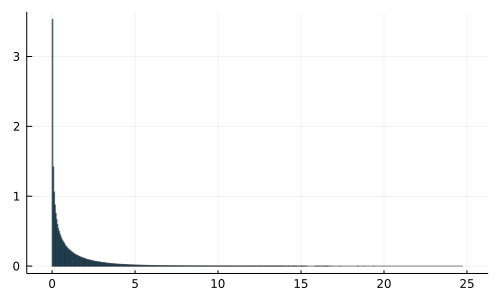

In [162]:
histogram(ChiSquared1())

We can get the $\chi_n^2$ distribution by summing several $\chi_1^2$:

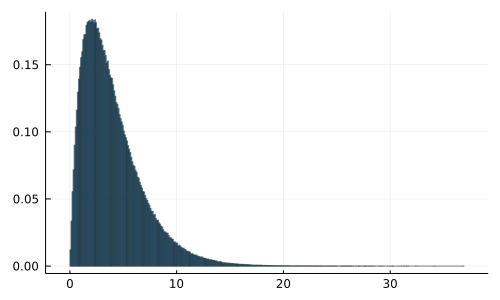

In [164]:
histogram(sum(ChiSquared1() for i in 1:4))

## Using symbolics

We can even do some of this symbolically!, e.g.:

In [167]:
@variables μ₁, σ₁², μ₂, σ₂²   # introduce symbolic variables from Symbolics.jl

(μ₁, σ₁², μ₂, σ₂²)

In [168]:
Gaussian(μ₁, σ₁²) + Gaussian(μ₂, σ₂²)

Gaussian(μ₁ + μ₂, σ₁² + σ₂²)

In [169]:
Gaussian(17, 3) + Gaussian(μ₂, σ₂²)

Gaussian(17 + μ₂, 3 + σ₂²)